In [1]:
!wget https://raw.githubusercontent.com/alexeygrigorev/datasets/master/course_lead_scoring.csv

--2025-11-09 16:30:48--  https://raw.githubusercontent.com/alexeygrigorev/datasets/master/course_lead_scoring.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 80876 (79K) [text/plain]
Saving to: ‘course_lead_scoring.csv’

course_lead_scoring 100%[===================>]  78.98K  --.-KB/s    in 0.07s   

2025-11-09 16:30:49 (1.15 MB/s) - ‘course_lead_scoring.csv’ saved [80876/80876]



In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, roc_curve

In [2]:
df = pd.read_csv("course_lead_scoring.csv")
df

,lead_source,industry,number_of_courses_viewed,annual_income,employment_status,location,interaction_count,lead_score,converted
0,paid_ads,NaN,1,79450.0,unemployed,south_america,4,0.94,1
1,social_media,retail,1,46992.0,employed,south_america,1,0.80,0
2,events,healthcare,5,78796.0,unemployed,australia,3,0.69,1
3,paid_ads,retail,2,83843.0,NaN,australia,1,0.87,0
4,referral,education,3,85012.0,self_employed,europe,3,0.62,1
...,...,...,...,...,...,...,...,...,...
1457,referral,manufacturing,1,NaN,self_employed,north_america,4,0.53,1
1458,referral,technology,3,65259.0,student,europe,2,0.24,1
1459,paid_ads,technology,1,45688.0,student,north_america,3,0.02,1
1460,referral,NaN,5,71016.0,self_employed,north_america,0,0.25,1


In [3]:
#fill missing values

non_numeric_cols = df.select_dtypes(exclude=['float', 'int']).columns
df[non_numeric_cols] = df[non_numeric_cols].fillna(np.nan)
df[non_numeric_cols]= df[non_numeric_cols].replace("", np.nan)

numeric_cols = df.select_dtypes(include=['float', 'int']).columns
df[numeric_cols] = df[numeric_cols].fillna(0)

#train test split
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1) # 0.25 x 0.8

roc_curve: when our required output is a yes or no, we need to convert our model's output to a yes/no

we run the same linear regression (through both ohe-categorical and numerical data). the output will be a number. how can we convert this model output to a yes/no? we first run it through the sigmoid function to get a probability between 0 and 1. The logistic regression function directly does this

we then need to set a threshold between 0,1 to say what all become yes and no. how do we know what to use?

we need to compare the ratio of FP, TP, FN and TN at each threshold point to determine the point at which FP/FN are lowest and TP/TN are highest. 
ROC (Receiver Operating Characteristic curve) plots false positive rate (FP / all negative outputs) vs true positive rate (TP/ all positive outputs). we want highest TPR (1), and lowest FPR (0). 

Roc_curve takes in our Y_predict and Y_real, and computes for each threshold point( btw 0 and 1) what TPR and FPR are. WE can find the best threshold point from here.
ROC_AUC_score: takes the same inputs, and gives us the area under the curve, the larger the number, the higher the difference between the FPR and TPR, and better model/prediction it is. 

In [4]:
# compute the "model" simply from all numeric features one at a time
# for each model/y_predict produced from each feature, calculate the roc auc score

features = numeric_cols.tolist()
features.remove('converted')  # remove target variable if present
model = LogisticRegression()
y_train = df_train['converted'].to_numpy()
y_val = df_val['converted'].to_numpy()

for feature in features:
    
    X_train = df_train[[feature]].to_numpy()
    model.fit(X_train, y_train)
    X_val = df_val[[feature]].to_numpy()
    y_pred = model.predict_proba(X_val)[:, 1]
    
    auc = roc_auc_score(y_val, y_pred)
    print(f'Feature: {feature}, ROC AUC: {auc:.3f}')


Feature: number_of_courses_viewed, ROC AUC: 0.742
Feature: annual_income, ROC AUC: 0.554
Feature: interaction_count, ROC AUC: 0.697
Feature: lead_score, ROC AUC: 0.623


In [5]:
# maybe they didnt want a model, they just wanted to use the feature directly
# y_predict=X_data, calculate the roc auc score

for feature in features:
    
    X_data = df_val[feature].to_numpy()
    y_pred = X_data  # using the feature directly as prediction
    
    auc = roc_auc_score(y_val, y_pred)
    print(f'Feature: {feature}, ROC AUC (direct): {auc:.3f}')


Feature: number_of_courses_viewed, ROC AUC (direct): 0.742
Feature: annual_income, ROC AUC (direct): 0.554
Feature: interaction_count, ROC AUC (direct): 0.697
Feature: lead_score, ROC AUC (direct): 0.623


In [6]:
# prepare data for modeling with all features: do OHE for categorical variables

ohe = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
def ohe_transform(X_Data):
    non_numeric_cols = X_Data.select_dtypes(exclude=['float', 'int']).columns
    numeric_cols = X_Data.select_dtypes(include=['float', 'int']).columns
    temp_ohe= ohe.fit_transform(X_Data[non_numeric_cols])
    X_Data_Ohe= pd.DataFrame(temp_ohe, columns=ohe.get_feature_names_out(non_numeric_cols))
    X_Data_Ohe.index = X_Data.index  # align indices
    return pd.concat([X_Data[numeric_cols], X_Data_Ohe], axis=1)

In [25]:
# train the logistic regression model with all features and find the ROC AUC score on validation set

df_train_withohe = ohe_transform(df_train)
df_val_withohe = ohe_transform(df_val)

model= LogisticRegression( C=1.0, max_iter=1000)
X_train= df_train_withohe.drop(columns=['converted']).to_numpy()
y_train= df_train_withohe['converted'].to_numpy()
X_val= df_val_withohe.drop(columns=['converted']).to_numpy()
y_val= df_val_withohe['converted'].to_numpy()

model.fit(X_train, y_train)
y_pred= model.predict_proba(X_val)[:, 1]
auc= roc_auc_score(y_val, y_pred)
print(f'ROC AUC (all features with OHE): {auc:.3f}')

ROC AUC (all features with OHE): 0.919


/Applications/miniforge3/envs/ml-zoomcamp/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 1000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=1000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


/Applications/miniforge3/envs/ml-zoomcamp/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 1000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=1000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


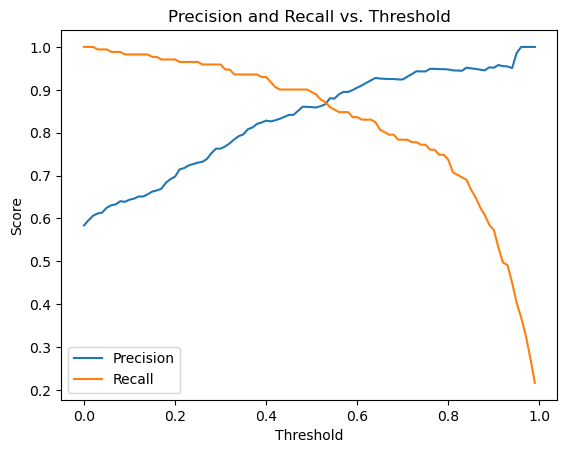

In [28]:
# valuate the model on all thresholds from 0.0 to 1.0 with step 0.01
# For each threshold, compute precision and recall
precision_scores = []
recall_scores = []

model.fit(X_train, y_train)
y_pred= model.predict_proba(X_val)[:, 1]

for t in np.arange(0.0, 1, 0.01):
    preds = (y_pred >= t).astype(int) #make 1 if y_pred >= t else 0
    precision_scores.append(precision_score(y_val, preds, zero_division=0))
    recall_scores.append(recall_score(y_val, preds))

plt.plot(np.arange(0.0, 1, 0.01), precision_scores, label='Precision')
plt.plot(np.arange(0.0, 1, 0.01), recall_scores, label='Recall')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Precision and Recall vs. Threshold')
plt.legend()


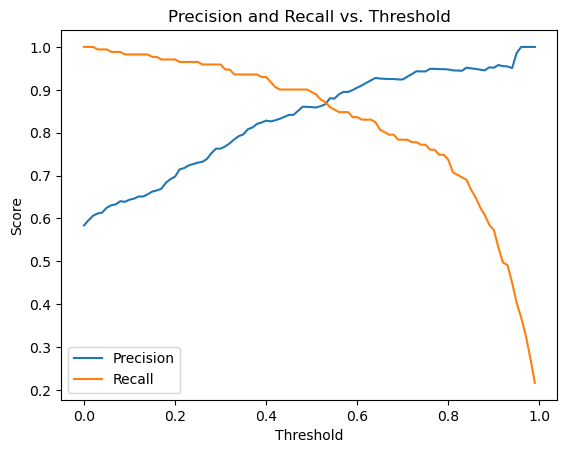

In [27]:
# alternatively do manually by making confusion matrix

y_pred= model.predict_proba(X_val)[:, 1]
y_val = df_val['converted'].to_numpy()
precision_scores = []
recall_scores = []

for t in np.arange(0.0, 1, 0.01):
    preds = (y_pred >= t).astype(int) #make 1 if y_pred >= t else 0
    tp = np.sum((y_val == 1) & (preds == 1))
    fp = np.sum((y_val == 0) & (preds == 1))
    fn = np.sum((y_val == 1) & (preds == 0))
    
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    
    precision_scores.append(precision)
    recall_scores.append(recall)

plt.plot(np.arange(0.0, 1, 0.01), precision_scores, label='Precision')
plt.plot(np.arange(0.0, 1, 0.01), recall_scores, label='Recall')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Precision and Recall vs. Threshold')
plt.legend()


Best threshold for F1 score: 0.48


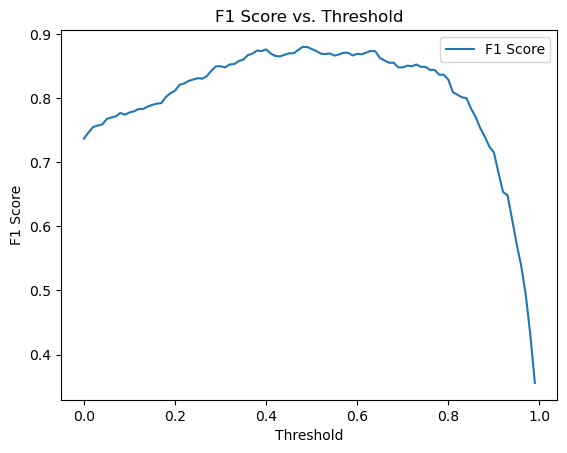

In [30]:
# compute F1 score for each threshold and find the threshold that gives the best F1 score
f1_scores = []
from sklearn.metrics import f1_score

for t in np.arange(0.0, 1, 0.01):
    preds = (y_pred >= t).astype(int) #make 1 if y_pred >= t else 0
    f1 = f1_score(y_val, preds, zero_division=0)
    f1_scores.append(f1)

best_threshold = np.arange(0.0, 1, 0.01)[np.argmax(f1_scores)]
print(f'Best threshold for F1 score: {best_threshold:.2f}')

plt.plot(np.arange(0.0, 1, 0.01), f1_scores, label='F1 Score')
plt.xlabel('Threshold')
plt.ylabel('F1 Score')
plt.title('F1 Score vs. Threshold')
plt.legend()

Best threshold for F1 score: 0.48


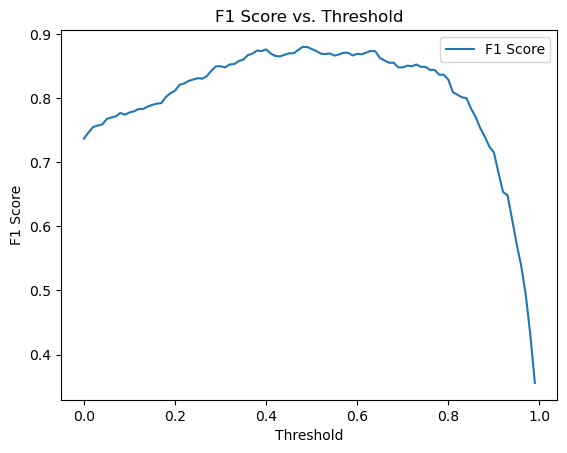

In [31]:
# compute F1 score for each threshold manually

f1_scores = []
for t in np.arange(0.0, 1, 0.01):
    preds = (y_pred >= t).astype(int) #make 1 if y_pred >= t else 0
    tp = np.sum((y_val == 1) & (preds == 1))
    fp = np.sum((y_val == 0) & (preds == 1))
    fn = np.sum((y_val == 1) & (preds == 0))
    
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    f1_scores.append(f1)
best_threshold = np.arange(0.0, 1, 0.01)[np.argmax(f1_scores)]
print(f'Best threshold for F1 score: {best_threshold:.2f}')

plt.plot(np.arange(0.0, 1, 0.01), f1_scores, label='F1 Score')
plt.xlabel('Threshold')
plt.ylabel('F1 Score')
plt.title('F1 Score vs. Threshold')
plt.legend()

In [58]:
# cross validate model with all features using 5 folds
model= LogisticRegression( C=1.0, max_iter=1000)
kf = KFold(n_splits=5, shuffle=True, random_state=1)
aucs_crossval = []

X_data = ohe_transform(df_full_train).drop(columns=['converted']).to_numpy()
y_data = df_full_train['converted'].to_numpy()


for train_idx, val_idx in kf.split(X_data):

    X_train, X_val = X_data[train_idx], X_data[val_idx]   
    y_train, y_val = y_data[train_idx], y_data[val_idx]

    model.fit(X_train, y_train)
    y_pred = model.predict_proba(X_val)[:, 1]
    auc = roc_auc_score(y_val, y_pred)
    aucs_crossval.append(auc)

print('mean: %.3f, std: %.3f' % (np.mean(aucs_crossval), np.std(aucs_crossval)))

/Applications/miniforge3/envs/ml-zoomcamp/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 1000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=1000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Applications/miniforge3/envs/ml-zoomcamp/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 1000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=1000).
You might also want to scale the data as shown in:
    https://sciki

mean: 0.921, std: 0.011


/Applications/miniforge3/envs/ml-zoomcamp/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 1000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=1000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Applications/miniforge3/envs/ml-zoomcamp/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 1000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=1000).
You might also want to scale the data as shown in:
    https://sciki

In [59]:
print('mean: %.3f, std: %.3f' % (np.mean(aucs_crossval), np.std(aucs_crossval)))

mean: 0.921, std: 0.011


In [60]:
# check which C is best for the regression model using cross validation
# which has highest mean and lowest std RoC AUC score  

X_data = ohe_transform(df_full_train).drop(columns=['converted']).to_numpy()
y_data = df_full_train['converted'].to_numpy()

C= [0.000001, 0.001, 1]
kf = KFold(n_splits=5, shuffle=True, random_state=1)
aucs_crossval_c_mean = []
aucs_crossval_c_std = []

for c in C:
    model = LogisticRegression(solver='liblinear', C=c, max_iter=1000)
    aucs_crossval = []

    for train_idx, val_idx in kf.split(X_data):

        X_train, X_val = X_data[train_idx], X_data[val_idx]   
        y_train, y_val = y_data[train_idx], y_data[val_idx]

        model.fit(X_train, y_train)
        y_pred = model.predict_proba(X_val)[:, 1]
        auc = roc_auc_score(y_val, y_pred)
        aucs_crossval.append(auc)
        
    mean_auc = np.mean(aucs_crossval)
    std_auc = np.std(aucs_crossval)
    aucs_crossval_c_mean.append(mean_auc)
    aucs_crossval_c_std.append(std_auc)
    print(f'C: {c}, Mean ROC AUC: {mean_auc:.3f}, Std ROC AUC: {std_auc:.3f}')


C: 1e-06, Mean ROC AUC: 0.560, Std ROC AUC: 0.024
C: 0.001, Mean ROC AUC: 0.867, Std ROC AUC: 0.029
C: 1, Mean ROC AUC: 0.822, Std ROC AUC: 0.036
